<h1 style="color:rgb(0,120,170)">Neural Networks and Deep Learning</h1>

## Implementing Neural Networks with Numpy

### Function approximation

Based on [this](https://towardsdatascience.com/error-backpropagation-5394d33ff49b) post

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1000)

In [2]:
class Layer:
    def __init__(self,dims,previous_layer=None,init_method='random_normal',activation='linear'):
        """
        parameters
        dims             : dims is a tuple containing two values (input_size, output_size)
        previous_layer   : instance of a previous layer
        init_method      : initialization method
        activation       : activation function. Only linear and Tanh have been implemented at the moment
        """
        self.dims = dims
        self.activation_func = activation
        self.previous_layer = None
        self.outs = None
        self.ins = None
        if previous_layer is not None:
            if previous_layer.dims[1] != self.dims[0]:
                raise Exception("Layers can't be attached!, {} != {}".format(previous_layer.dims[1],self.dims[0]))
            self.weights = np.random.normal(size=self.dims)
            self.bias = np.random.normal(size=(self.dims[1]))
            self.previous_layer = previous_layer
        else:
            self.weights = np.random.normal(size=self.dims)
            self.bias = np.random.normal(size=(self.dims[1]))
            
    def forward_prop(self,inputs):
        return inputs @ self.weights + self.bias
    
    def activation(self,inputs):
        if self.activation_func == 'tanh':
            return np.tanh(inputs)
        else:
            return inputs
        
    def derivative_of_activation(self,inputs):
        if self.activation_func == 'tanh':
            return 1 - self.activation(inputs)**2
        elif self.activation_func == 'linear':
            return np.ones(inputs.shape)
        else:
            pass
        
    def gradient_descent(self,grads_w, grads_b, steps):
        self.weights -= steps*grads_w
        self.bias -= steps*grads_b
        
    def calc_prev_layer_error(self,derivative,weights,error):
        N,M = derivative.shape
        Sum = np.zeros((M,N))
        for i in range(N):
            Is = np.zeros((N,N))
            Ir = np.zeros((N,N))
            Is[0][i] = 1
            Ir[i][i] = 1
            Sum += np.diag((Is @ derivative)[0][:])@((weights @ error) @ Ir)
        return Sum
    
    def back_prop(self,error,steps):
        if self.previous_layer is None:
            
            #compute gradients
            grads_w = error @ self.ins
            grads_b = np.sum(error,axis=1)
            #update weights with gradient descent
            self.gradient_descent(grads_w.T,grads_b,steps)
        else:
            #compute derivatives
            d = self.previous_layer.derivative_of_activation(self.previous_layer.outs)
            #estimate previous layer error
            layer_error = self.calc_prev_layer_error(d,self.weights,error)
            
            #Compute gradients
            grads_w = error @ self.previous_layer.activation(self.ins)
            grads_b = np.sum(error,axis=1)
            
            self.gradient_descent(grads_w.T, grads_b, steps)

            self.previous_layer.back_prop(layer_error,steps)
        
        
    def __call__(self,inputs):
        if self.previous_layer is None:
            self.ins = inputs
            self.outs = self.forward_prop(self.ins)
            return self.activation(self.outs)
        else:
            self.ins = self.previous_layer(inputs)
            self.outs = self.forward_prop(self.ins)
            return self.activation(self.outs)

In [3]:
class Data:
    def __init__(self,X,y,batch_size):
        self.batch_size =  batch_size
        self.X = X
        self.y = y
    def __next__(self):
        choices = np.random.choice(self.X.shape[0],self.batch_size)
        x_ = self.X[choices]
        y_ = self.y[choices]
        return x_, y_
        

In [4]:
class Model:
    def __init__(self,network,loss_func='rms'):
        self.network = network
        self.loss_func = loss_func
    def fit(self,generator, epochs=10,steps=0.1):
        """
        This function is responsible for the training of the NN
        Params
        generator    : Instance of a data generator class
        epochs       : Number of training epochs
        steps        : step size for gradient descent
        """
        for epoch in range(epochs):
            x_train, y_train = next(generator)
            #forward propagation
            y = self.network(x_train)
            error_sigma = self.loss(y,y_train)
            #Error backpropagation
            self.network.back_prop(error_sigma,steps)
            Error = self.error(y,y_train)
            print("Epoch: {}  Error: {}".format(epoch,Error))
            
    def loss(self,y,t):
        if self.loss_func == 'rms':
            return (y - t).T
        elif self.loss_func == 'logits':
            pass
    def error(self,y,t):
        if self.loss_func == 'rms':
            e = (y - t)**2
            e = 0.5*np.mean(e)
            return np.sqrt(e)
        
    def predict(self,X_test):
        return self.network(X_test)

In [5]:
def f(x):
    return np.sin(2*x) + np.cos(x)+ 5

In [6]:
#Dataset size
N = 10000
#Real process data
x = np.linspace(-5,5,1000).reshape(-1,1)
y = f(x)
#Data and parameter (i.e. prior) standard deviations
sigma_data = 0.2
sigma_params = 0.5

#simulate noise in measurements
data_noise = np.random.normal(0, sigma_data, N).reshape(-1,1)

#Generate training data i.e x
X_train = np.random.uniform(-5,5,N).reshape(-1,1)
Y_train = f(X_train) + data_noise

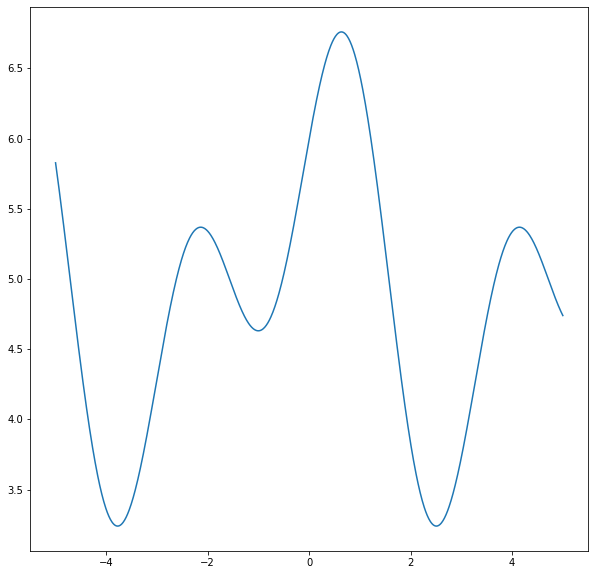

In [7]:
plt.figure(figsize=(10,10))
plt.plot(x,y,label="Real process")
# plt.legend()
plt.show()

In [8]:
#Create network
L1 = Layer((1,12),activation='tanh')
L2 = Layer((12,32),L1, activation='tanh')
L3 = Layer((32,12),L2, activation='tanh')
network = Layer((12,1),L3)

model = Model(network)
batch_size = 100
datagen = Data(X_train,Y_train,batch_size)

#Training
model.fit(datagen,epochs=100,steps=0.0001)

Epoch: 0  Error: 3.904802590402042
Epoch: 1  Error: 3.183046709829194
Epoch: 2  Error: 2.1734916938063904
Epoch: 3  Error: 1.834758341688934
Epoch: 4  Error: 1.7260855741245198
Epoch: 5  Error: 1.395792807240209
Epoch: 6  Error: 0.9264621836752963
Epoch: 7  Error: 0.8002976142081987
Epoch: 8  Error: 0.865068662154362
Epoch: 9  Error: 0.7329435466119424
Epoch: 10  Error: 0.7705927685023717
Epoch: 11  Error: 0.712300263300278
Epoch: 12  Error: 0.7206529208224296
Epoch: 13  Error: 0.7459805194738658
Epoch: 14  Error: 0.793984043641758
Epoch: 15  Error: 0.6628380856640546
Epoch: 16  Error: 0.6772242976575075
Epoch: 17  Error: 0.7604268467611778
Epoch: 18  Error: 0.6928944931213197
Epoch: 19  Error: 0.7506510673894214
Epoch: 20  Error: 0.6728819176529838
Epoch: 21  Error: 0.7290304700367026
Epoch: 22  Error: 0.6686620282504991
Epoch: 23  Error: 0.6776354616668115
Epoch: 24  Error: 0.6609556955387033
Epoch: 25  Error: 0.6741505875714547
Epoch: 26  Error: 0.6337310846220845
Epoch: 27  Error: 

In [9]:
#model.fit(datagen,epochs=100,steps=0.0005)

In [10]:
X_test = np.linspace(-5,5,1000).reshape(-1,1)
predicted = model.predict(X_test)

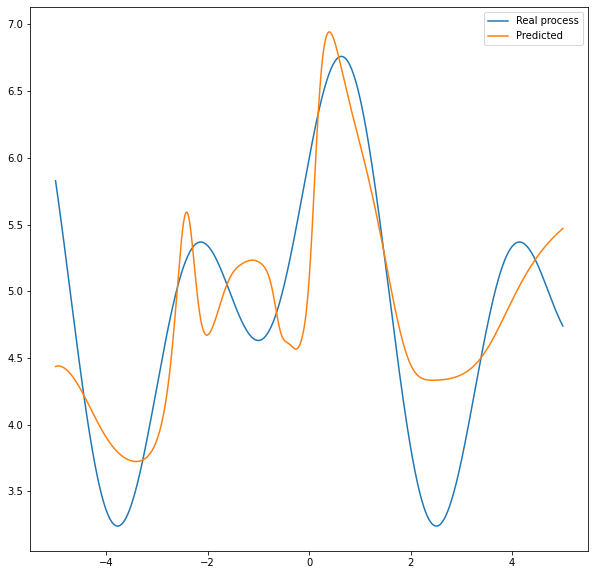

In [11]:
plt.figure(figsize=(10,10))
plt.plot(x,y,label="Real process")
plt.plot(X_test,predicted,label="Predicted")
plt.legend()
plt.show()